In [33]:
# Standard library imports
import os
import re
import json
from collections import Counter, defaultdict
import unicodedata

# Natural Language Processing
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import ngrams, pos_tag
import spacy

# Data Processing and Analysis
import numpy as np
import pandas as pd
from scipy.stats import entropy
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
import networkx as nx

In [34]:
def texts_to_dataframe(directory_path=None, file_paths=None):
    data = []
    
    # If directory path is provided, get all text files from directory
    if directory_path:
        file_paths = [
            os.path.join(directory_path, f) 
            for f in os.listdir(directory_path) 
            if f.endswith('.txt')
        ]
    
    # Process each file
    if file_paths:
        for file_path in file_paths:
            try:
                with open(file_path, 'r', encoding='utf-8') as file:
                    content = file.read()
                    filename = os.path.basename(file_path)
                    data.append({
                        'filename': filename,
                        'content': content
                    })
            except Exception as e:
                print(f"Error reading file {file_path}: {str(e)}")
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    return df

def clean_dictionary(input_dict):
    def clean_text(text):
        # Convert to lowercase and remove extra whitespace/linebreaks
        return ' '.join(text.lower().split())
    
    cleaned_dict = {}
    for key, value in input_dict.items():
        if isinstance(value, list):
            # If value is a list, clean each string in the list
            cleaned_dict[key] = [clean_text(item) for item in value]
        elif isinstance(value, str):
            # If value is a string, clean it directly
            cleaned_dict[key] = clean_text(value)
        else:
            # Preserve non-string values as is
            cleaned_dict[key] = value
            
    return cleaned_dict

In [35]:
df = texts_to_dataframe(directory_path='pdf_texts')

In [36]:
#apply lowercase to all text
df['content'] = df['content'].str.lower()

In [37]:
def clean(x):
    x = re.sub(r'^RT[\s]+', '', x)
    x = re.sub(r'https?:\/\/.*[\r\n]*', '', x)
    x = re.sub(r'#', '', x)
    x = re.sub(r'@[A-Za-z0-9]+', '', x)
    
    # Remove dates in various formats
    # DD/MM/YYYY or MM/DD/YYYY
    x = re.sub(r'\b\d{1,2}\/\d{1,2}\/\d{2,4}\b', '', x)
    
    # YYYY-MM-DD
    x = re.sub(r'\b\d{4}-\d{1,2}-\d{1,2}\b', '', x)
    
    # DD-MM-YYYY or MM-DD-YYYY
    x = re.sub(r'\b\d{1,2}-\d{1,2}-\d{2,4}\b', '', x)
    
    # Standalone years (1900-2099)
    x = re.sub(r'\b(19|20)\d{2}\b', '', x)
    
    # Month names with dates
    months = r'(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)'
    x = re.sub(rf'\b{months}\s+\d{{1,2}}(?:st|nd|rd|th)?\s*,?\s*\d{{4}}?\b', '', x, flags=re.IGNORECASE)
    
    # Remove ordinal dates (1st, 2nd, 3rd, 4th)
    x = re.sub(r'\b\d+(st|nd|rd|th)\b', '', x, flags=re.IGNORECASE)
    
    # Remove alphanumeric codes
    x = re.sub(r'\b[A-Za-z0-9]+[\/\-][A-Za-z0-9\/\-]+\b', '', x)
    
    # Remove standalone numbers/special patterns
    x = re.sub(r'\b\w{1,2}\b', '', x)  # Short words/numbers
    x = re.sub(r'\b[A-Za-z0-9]{3,}\/[A-Za-z0-9]{3,}\b', '', x)  # Complex codes
    
    # Remove time formats (HH:MM or HH:MM:SS)
    x = re.sub(r'\b\d{1,2}:\d{2}(:\d{2})?\b', '', x)
    
    # Remove year ranges (e.g., 2020-2021)
    x = re.sub(r'\b\d{4}-\d{4}\b', '', x)
    
    # Remove remaining punctuation and special characters
    x = re.sub(r'[^\w\s]', '', x)
    
    # Clean up whitespace
    x = re.sub(r'\s+', ' ', x).strip()
    
    return x

In [38]:
df['content'] = df['content'].apply(clean)

In [39]:
#additional removal of words

stop_words = set(stopwords.words('english'))

add_stopwords = [
    # Original common report words
    'introduction', 'background', 'methodology', 'conclusion', 'conclusions', 'recommendations', 
    'summary', 'annex', 'paragraph', 'page', 'pages', 'title', 'section', 'attachment', 'appendix',
    'reference', 'regarding', 'note', 'noted', 'subject', 'date', 'description', 'strictly', 'tender', 'state',
    'confidential', 'administrative', 'official', 'internal', 'external', 'oversight', 'described', 'investigative',
    'obtained', 'indicated', 'recorded', 'collected', 'prepared', 'established', 'followed',
    'considered', 'referred', 'requested', 'reviewed', 'received', 'submitted', 'provided',
    'conducted', 'furthermore', 'moreover', 'additionally', 'likewise', 'subsequently', 'appendices',
    'therefore', 'however', 'accordingly', 'namely', 'specifically', 'addition', 'regarding','file',

    'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december',
    'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'sept', 'oct', 'nov', 'dec',
    'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday',
    'mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun',
    
    # Additional time-related words
    'year', 'month', 'day', 'hour', 'ago', 'today', 'tomorrow', 'yearly', 'monthly', 'daily',
    'morning', 'evening', 'night', 'afternoon', 'weekend', 'weekday', 'period', 'duration',
    'season', 'interval', 'currently', 'previously', 'summer', 'winter', 'spring', 'fall',
    
    # Numbers and counting words
    'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten',
    'first', 'second', 'third', 'forth', 'i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii',
    'viii', 'ix', 'x', 'xi', 'xii', 'xiii', 'xiv', 'xv', 'xvi', 'xvii', 'xviii', 'xix', 'xx',
    
    # Document and process related
    'document', 'documentation', 'report', 'letter', 'memo', 'correspondence', 'form',
    'invoice', 'receipt', 'file', 'record', 'sheet', 'process', 'procedure', 'method',
    'approach', 'system', 'practice', 'protocol', 'policy', 'regulation', 'requirement',
    'guideline', 'approximately', 'estimated', 'about', 'roughly', 'nearly', 'almost',
    'around', 'see', 'note', 'refer', 'indicate', 'show', 'demonstrate', 'highlight',
    'ensure', 'maintain', 'support', 'provide',
    
    # Additional administrative terms
    'supervisor', 'assistant', 'officer', 'senior', 'manager', 'staff', 'personnel',
    'business', 'organization', 'department', 'unit', 'division', 'office', 'section',
    'position', 'duty', 'responsibility', 'authority', 'appropriate', 'relevant',
    'sufficient', 'applicable', 'present', 'current', 'previous', 'subsequent',
    'following', 'prior', 'further',
    # Agency/Department terms
    'directorate', 'committee', 'branch', 'commission', 'pillar', 'secretariat',
    'headquarters', 'tribunal', 'taskforce', 'task force', 'agency', 'board',
    'institution', 'entity', 'bureau', 'council','code',

    # Document/Report sections
    'allegation', 'findings', 'executive', 'annexure', 'foreword', 'preamble',
    'introduction', 'clause', 'article', 'paragraph', 'subsection', 'pursuant',
    'provisional', 'draft', 'final', 'revised', 'amended',

    # Status/Action words
    'pending', 'ongoing', 'completed', 'terminated', 'suspended', 'implemented',
    'issued', 'forwarded', 'dispatched', 'endorsed', 'authorized', 'approved',
    'initiated', 'undertaken', 'processed', 'executed', 'finalized',

    # Common descriptors
    'hereby', 'therein', 'thereof', 'herewith', 'whereby', 'hereof', 'thereto',
    'aforementioned', 'abovementioned', 'said', 'pertaining', 'concerning',
    'respective', 'relevant',

    # Administrative terms
    'administering', 'coordinating', 'facilitating', 'implementing', 'overseeing',
    'supervising', 'managing', 'directing', 'governing', 'regulating',
    'procurement', 'bidding', 'tendering', 'contracting',

    # Common prepositions/conjunctions in formal docs 
    'pursuant', 'notwithstanding', 'whereas', 'hereinafter', 'forthwith',
    'henceforth', 'hereto', 'thereof', 'therein', 'thereto',

    # Additional titles/roles
    'director', 'coordinator', 'administrator', 'representative', 'delegate',
    'consultant', 'adviser', 'specialist', 'analyst', 'official', 'participant',
    'inspector', 'auditor', 'investigator', 'evaluator',

    # File/Document types
    'memorandum', 'circular', 'notification', 'advisory', 'bulletin', 'directive',
    'guideline', 'instruction', 'mandate', 'protocol', 'regulation', 'statute',

    # others
    'sigint', 'itf', 'office', 'internal', 'information', 'services', 'interoffice', 'shopping','unmik','undp',
    'procurement', 'nsa', 'kosovo', 'oversight', 'unies', 'united', 'nation', 'nations', 'activity','unon', 'maintenance', 'nature',
    'interim', 'mission', 'administration', 'investigation', 'description', 'restraint', 'heard','possibility','aircraft',
    'author', 'link', 'non', 'bill', 'total', 'owned', 'receipt', 'shirt', 'au', 'record','set','give','hand','agree',
    'appears', 'showed', 'kept', 'carried', 'clear', 'check', 'available', 'notice', 'acknowledged', 'conduct', 'function', 'effort', 'various', 'standard', 'purpose', 'instruction',
    'connection', 'relation', 'provision', 'identity', 'requirement', 'favour', 'storage','submitting','principal','good','award',
    'kept', 'showed', 'clear', 'available', 'authorization', 'instruction', 'requirement', 'file', 'rec', 'sgb', 'secret', 'forged', 'construction', 'terminal', 'appears', 'various', 'clear',
    'name', 'ministry', 'highlight', 'case', 'alleged', 'evidence', 'responsible', 'regard','secretarygeneral','itb',
    'activity', 'position', 'duty', 'support', 'way', 'reference', 'purchase', 'good', 'example','confirm','limited','launch',
    'design', 'st', 'sgb', 'redacted', 'pay', 'complaint', 'opening', 'single', 'quality','selected','problem','created','receipt','learned',
    'model', 'product', 'main', 'justification', 'brochure', 'figure', 'legal', 'national', 'type','chartered', 'accountant',
    'approach', 'comment', 'supervisor', 'authority', 'business', 'involved', 'policy', 'ptf', 'ptfr', 'addition','data', 'suggestion','suggest','suggests',
    'enterprise', 'indicate', 'view', 'special', 'asset', 'arising', 'jurisdiction', 'mail', 'similar', 'type', 'note', 'instruct',
    'able', 'discussion', 'subsequent', 'sufficient', 'prepare', 'supporting', 'competitor', 'file', 'dot', 'infrastructure',
    'employment', 'transport', 'air', 'euro', 'requested', 'took', 'come', 'ensure', 'appear', 'lower','simple','remains',
    'present', 'contact', 'relation', 'question', 'presence', 'attention', 'oios', 'lowest', 'advance', 'particular','driving',
    'intérimaire', 'wrote', 'advised', 'accepted', 'attended', 'obtain', 'named', 'file', 'taken', 'sgb273', 'provision',
    'relating', 'approved', 'unable', 'high', 'confidential', 'civil', 'appointment', 'notification', 'cancellation', 'inquiry', 'rule', 'id',
    'interimaire', 'firm', 'group', 'partner', 'leadership', 'behalf', 'file', 'make', 'recommends', 'planned', 'test', 'return',
    'interim', 'preparation', 'requirement', 'approved', 'accepted', 'amount', 'number', 'plan', 'until', 'pillar', 'asset',
    'attended', 'obtain', 'advised', 'car', 'equipment', 'unable', 'adduced', 'sent', 'clear', 'intérimaire','annual', 'instruct',
    ' intérimaire', 'intérimaire\n', 'intérimaire\t', 'intérimaire','secreatarygeneral','best','government','known','settle', 'purpose',
    'preparation', 'goal', 'global', 'quantity', 'highlights', 'nied', 'des', 'wikileaks', 'keywords', 'working','ip54','claim', 'bank',
    'worked', 'denied', 'seen', 'placed', 'obtained', 'continue', 'indicating', 'admitted', 'believed', 'held', 'necessary', 'able', 'improper', 'normal', 'additional',
    'situation', 'performance', 'term', 'course', 'value', 'limit', 'chief', 'assistance', 'activity', 'communication',
    'claim', 'need', 'record', 'requirement', 'session', 'training', 'function', 'quantity', 'enterprise', 'additional', 'necessary', 'improper'
]
stop_words.update(add_stopwords)


In [40]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    # Handle NaN/None values
    if pd.isna(text):
        return text
    # Split into words
    words = str(text).split()
    # Lemmatize each word
    lemmatized_words = [lemmatizer.lemmatize(word.lower()) for word in words]
    # Join back into text
    return ' '.join(lemmatized_words)

def clean_text(text):
    text = str(text).lower()
    words = text.split()
    return ' '.join([word for word in words if word.strip() not in stop_words])

In [41]:
#apply nltk and custom stopwords
df['content_clean'] = df['content'].apply(clean_text)

#lemmatize all words
df['content_lemmatized'] = df['content_clean'].apply(lemmatize_text)
df.head()

,filename,content,content_clean,content_lemmatized
0,1.txt,page united nations nations unies united natio...,task force pristina pristina airport possible ...,task force pristina pristina airport possible ...
1,10.txt,page united nations nations unies united natio...,task force irregularities extension cargo apro...,task force irregularity extension cargo apron ...
2,105.txt,page nsa global sigint highlights intercepts a...,intercepts abe carbon emissions organisation r...,intercept abe carbon emission organisation rel...
3,106.txt,page nsa global sigint highlights spies japan ...,spies japan doubles carbon emissions release s...,spy japan double carbon emission release secur...
4,107.txt,page nsa global sigint highlights bugged japan...,bugged japan proposals climate change release ...,bugged japan proposal climate change release s...


In [42]:
class TextPreprocessor:
    def __init__(self, entities_dict):
        # Load spaCy model
        self.nlp = spacy.load('en_core_web_sm')
        
        # Define important POS tags to keep
        self.important_pos = {
            'NOUN',      # nouns
            'PROPN',     # proper nouns
            'VERB',      # verbs
            'ADJ',       # adjectives
        }
        
        # Process entities dictionary to create preserved entities
        self.preserved_entities = self.process_entities_dict(entities_dict)
        
    def process_entities_dict(self, entities_dict):
        """
        Process entities dictionary where format is {category: [list of entities]}
        """
        preserved_entities = set()
        
        # Process each category and its entities
        for category, entity_list in entities_dict.items():
            # Add the category itself if it's a proper noun or named entity
            doc = self.nlp(category)
            if any(token.pos_ == 'PROPN' or 
                token.ent_type_ in {'ORG', 'GPE', 'PERSON'} 
                for token in doc):
                preserved_entities.add(category.lower())
            
            # Process each entity in the list
            for entity in entity_list:
                if entity:  # Check if entity is not empty
                    doc = self.nlp(entity)
                    if any(token.pos_ == 'PROPN' or 
                        token.ent_type_ in {'ORG', 'GPE', 'PERSON'} 
                        for token in doc):
                        preserved_entities.add(entity.lower())
        
        return preserved_entities

    def remove_short_words(self, text, min_length=2):
        """Remove words shorter than or equal to min_length characters"""
        words = str(text).split()
        return ' '.join([word for word in words if len(word) > min_length])

    def get_high_frequency_words(self, texts, threshold):
        """Identify high frequency words"""
        doc_frequency = Counter()
        total_docs = len(texts)
        
        for text in texts:
            words = str(text).lower().split()
            for word in words:
                doc_frequency[word] += 1
        
        frequent_words = {word for word, count in doc_frequency.items() 
                         if (count/total_docs > threshold)}
        
        return frequent_words - self.preserved_entities

    def get_low_info_words(self, texts, threshold=2.0):
        """Identify low information words based on entropy"""
        word_dist = {}
        for text in texts:
            words = str(text).lower().split()
            for word in words:
                if word not in word_dist:
                    word_dist[word] = []
                word_dist[word].append(words.count(word))
        
        low_info_words = set()
        for word, dist in word_dist.items():
            if len(dist) > 2:
                try:
                    word_entropy = entropy(dist)
                    if word_entropy < threshold:
                        low_info_words.add(word)
                except Exception:
                    pass
        
        return low_info_words - self.preserved_entities

    def filter_by_pos(self, text):
        """Filter text based on POS tags and named entities"""
        doc = self.nlp(str(text))
        
        # Get named entities
        entities = {ent.text.lower() for ent in doc.ents 
                   if ent.label_ in {'ORG', 'PERSON', 'GPE', 'LOC'}}
        
        # Get words with important POS tags
        important_words = {token.text.lower() for token in doc 
                          if token.pos_ in self.important_pos}
        
        # Combine with preserved entities
        keep_words = important_words | entities | self.preserved_entities
        
        # Filter words
        words = str(text).lower().split()
        return ' '.join([word for word in words if word in keep_words])

    def process_dataframe(self, df, text_column, freq_threshold=0.7):
        """Process entire dataframe"""
        texts = df[text_column].tolist()
        
        # First remove short words
        texts = [self.remove_short_words(text) for text in texts]
        
        # Get stopwords
        frequent_words = self.get_high_frequency_words(texts, freq_threshold)
        low_info_words = self.get_low_info_words(texts)
        all_stopwords = frequent_words | low_info_words
        
        def full_cleaning(text):
            # Remove short words
            text = self.remove_short_words(text)
            # Apply POS filtering
            text = self.filter_by_pos(text)
            # Remove stopwords
            words = str(text).lower().split()
            return ' '.join([word for word in words 
                           if word not in all_stopwords or word in self.preserved_entities])
        
        # Create new column with cleaned text
        df[f'{text_column}_enhanced_clean'] = df[text_column].apply(full_cleaning)
        
        # Print statistics
        print(f"Number of frequent words removed: {len(frequent_words)}")
        print(f"Number of low information words removed: {len(low_info_words)}")
        print(f"Total unique stopwords removed: {len(all_stopwords)}")
        print(f"Preserved Entities: {len(self.preserved_entities)}")

        return df, all_stopwords

In [43]:
with open('entities.json', 'r') as file:
    entities_dict = json.load(file)
preprocessor = TextPreprocessor(entities_dict)
df, all_stopwords = preprocessor.process_dataframe(df, 'content_lemmatized')

Number of frequent words removed: 136
Number of low information words removed: 926
Total unique stopwords removed: 1062
Preserved Entities: 1135


In [44]:
df.tail()

,filename,content,content_clean,content_lemmatized,content_lemmatized_enhanced_clean
39,8.txt,page united nations nations unies united natio...,task force allegations irregularities processe...,task force allegation irregularity process sup...,arises statement accountant led corruption pro...
40,82.txt,page united nations nations unies office inter...,task force protected provisions walter cabrera...,task force protected provision walter cabrera ...,protected provision walter cabrera walter cabr...
41,89.txt,page nsa global sigint highlights intercepts f...,intercepts france complaining intercepts franc...,intercept france complaining intercept france ...,intercept france complaining intercept france ...
42,9.txt,page united nations nations unies axa united n...,axa task force irregularities source contract ...,axa task force irregularity source contract co...,container container arises statement accountan...
43,91.txt,page nsa global sigint highlights spying frenc...,spying french ambassador contemplated exposing...,spying french ambassador contemplated exposing...,french ambassador contemplated exposing iraq t...


In [45]:
class TopicModelingCore:
    def __init__(self):
        self.vectorizer = None
        self.model = None
        self.coherence_scores = None
        
    def compute_coherence_score(self, doc_term_matrix, term_rankings):
        """
        Compute topic coherence score using term co-occurrence
        """
        if not isinstance(doc_term_matrix, csr_matrix):
            doc_term_matrix = csr_matrix(doc_term_matrix)
            
        vocab = self.vectorizer.get_feature_names_out()
        vocab_dict = {term: idx for idx, term in enumerate(vocab)}
        
        coherence_scores = []
        for topic_terms in term_rankings:
            # Get term indices
            term_pairs = []
            for i, term1 in enumerate(topic_terms):
                if term1 in vocab_dict:
                    for term2 in topic_terms[i+1:]:
                        if term2 in vocab_dict:
                            term_pairs.append((vocab_dict[term1], vocab_dict[term2]))
            
            # Compute pair-wise coherence scores
            pair_scores = []
            for term1_idx, term2_idx in term_pairs:
                # Get document frequencies
                term1_docs = doc_term_matrix[:, term1_idx].nonzero()[0]
                term2_docs = doc_term_matrix[:, term2_idx].nonzero()[0]
                both_docs = set(term1_docs).intersection(set(term2_docs))
                
                # Compute score
                if len(both_docs) > 0:
                    score = np.log((len(both_docs) + 1) / 
                                 (len(term1_docs) * len(term2_docs) + 1))
                    pair_scores.append(score)
            
            # Average pair scores for topic coherence
            topic_coherence = np.mean(pair_scores) if pair_scores else 0
            coherence_scores.append(topic_coherence)
        
        return np.mean(coherence_scores)
        
    def apply_topic_modeling(self, df, text_column, num_topics=None, min_topics=5, max_topics=30, step=5):
        """
        Apply enhanced topic modeling with optimized parameters
        """
        # Initialize vectorizer with optimized thresholds
        self.vectorizer = TfidfVectorizer(
            max_df=0.7,    
            min_df=4,      
            ngram_range=(1, 1),
            stop_words='english'
        )
        
        # Create document-term matrix
        doc_term_matrix = self.vectorizer.fit_transform(df[text_column])
        
        if num_topics is None:
            print("Finding optimal number of topics...")
            num_topics, self.model, self.vectorizer, doc_term_matrix = self.find_optimal_topics(
                df[text_column],
                min_topics=min_topics,
                max_topics=max_topics,
                step=step
            )
            print(f"Optimal number of topics: {num_topics}")
        else:
            self.model = LatentDirichletAllocation(
                n_components=num_topics,
                random_state=42,
                learning_method='batch',
                max_iter=100,
                learning_decay=0.9,        
                doc_topic_prior=0.05,      
                topic_word_prior=0.001     
            )
            self.model.fit(doc_term_matrix)
        
        # Transform documents
        doc_topics = self.model.transform(doc_term_matrix)
        feature_names = self.vectorizer.get_feature_names_out()
        
        # Create topic summaries
        topic_summaries = []
        for topic_idx, topic in enumerate(self.model.components_):
            top_words_idx = topic.argsort()[:-11:-1]
            topic_words = [(feature_names[i], topic[i]) for i in top_words_idx]
            topic_summaries.append({
                'topic_id': topic_idx + 1,
                'words': topic_words
            })
        
      
        df['dominant_topic'] = doc_topics.argmax(axis=1) + 1
        topic_probs = pd.DataFrame(
            doc_topics,
            columns=[f'Topic_{i+1}_Prob' for i in range(num_topics)]
        )
        df = pd.concat([df, topic_probs], axis=1)
        
        return df, topic_summaries
    
    def find_optimal_topics(self, data, min_topics=5, max_topics=30, step=5):
        """
        Find optimal number of topics using coherence scores
        """
        coherence_scores = []
        models = []
        vectorizers = []
        doc_term_matrices = []
        
        for num_topics in range(min_topics, max_topics + 1, step):
            print(f"Testing model with {num_topics} topics...")
            
            vectorizer = TfidfVectorizer(
                max_df=0.8,
                min_df=3,
                ngram_range=(1,2),
                stop_words='english'
            )
            doc_term_matrix = vectorizer.fit_transform(data)
            
            model = LatentDirichletAllocation(
                n_components=num_topics,
                random_state=42,
                learning_method='batch',
                max_iter=100,
                learning_decay=0.9,
                doc_topic_prior=0.05,
                topic_word_prior=0.001
            )
            
            model.fit(doc_term_matrix)
            
            # Get term rankings
            term_rankings = []
            feature_names = vectorizer.get_feature_names_out()
            for topic_idx in range(num_topics):
                top_terms = [feature_names[i] for i in 
                           model.components_[topic_idx].argsort()[:-10-1:-1]]
                term_rankings.append(top_terms)
            
            self.vectorizer = vectorizer 
            coherence = self.compute_coherence_score(doc_term_matrix, term_rankings)
            coherence_scores.append(coherence)
            models.append(model)
            vectorizers.append(vectorizer)
            doc_term_matrices.append(doc_term_matrix)
        
        # Find optimal model
        optimal_idx = np.argmax(coherence_scores)
        optimal_num_topics = range(min_topics, max_topics + 1, step)[optimal_idx]
        
        # Plot coherence scores
        plt.figure(figsize=(10, 6))
        plt.plot(range(min_topics, max_topics + 1, step), coherence_scores, marker='o')
        plt.xlabel('Number of Topics')
        plt.ylabel('Coherence Score')
        plt.title('Topic Coherence Scores vs Number of Topics')
        plt.show()
        
        return (optimal_num_topics, models[optimal_idx], 
                vectorizers[optimal_idx], doc_term_matrices[optimal_idx])
    
    def print_topics(self, topic_summaries, threshold=0.01):
        """
        Print topics with relevance scores
        Only show terms with relevance > 0.01
        """
        print("\nDiscovered Topics:")
        for topic in topic_summaries:
            print(f"\nTopic {topic['topic_id']}:")
            words = []
            for word, score in topic['words']:
                if score > threshold:
                    words.append(f"{word} ({score:.3f})")
            print(", ".join(words))
    
    def plot_topic_distribution(self, df):
        """Plot distribution of documents across topics"""
        plt.figure(figsize=(12, 6))
        topic_counts = df['dominant_topic'].value_counts().sort_index()
        sns.barplot(x=topic_counts.index, y=topic_counts.values)
        plt.title('Distribution of Documents Across Topics')
        plt.xlabel('Topic Number')
        plt.ylabel('Number of Documents')
        plt.show()
        
    def plot_topic_correlations(self, df):
        """Plot correlation between topics"""
        topic_cols = [col for col in df.columns if col.startswith('Topic_') and col.endswith('_Prob')]
        corr_matrix = df[topic_cols].corr()
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Topic Correlations')
        plt.show()


Finding optimal number of topics...
Testing model with 5 topics...
Testing model with 6 topics...
Testing model with 7 topics...
Testing model with 8 topics...


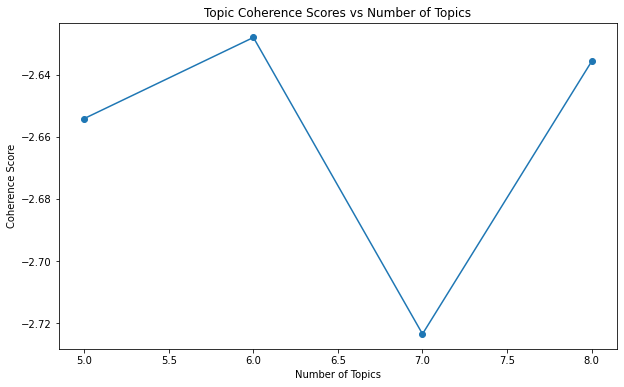

Optimal number of topics: 6

Discovered Topics:

Topic 1:
president (1.528), police (1.445), italy (1.385), kta (1.156), fraudulent (0.866), relation (0.806), ambassador (0.791), capital (0.784), minister (0.691), respect (0.675)

Topic 2:
climate (1.913), summit (1.575), japan (1.402), economy (0.787), trade (0.741), vat (0.653), invoice (0.649), damage (0.642), agriculture (0.587), country (0.511)

Topic 3:
vendor (7.545), peap (2.314), vendor vendor (2.144), justice (1.430), tender (1.034), judicial (0.919), criminal (0.917), requirement (0.853), advantage (0.797), written (0.787)

Topic 4:
french (1.677), emission (1.212), expense (1.187), violation (1.096), washington (1.028), european (1.026), carbon emission (0.977), intelligence (0.916), intercept (0.853), carbon (0.838)

Topic 5:
law (1.882), tax (1.499), kta (1.476), kfor (1.403), flight (1.222), time (1.138), conflict (0.986), asset (0.978), corruption (0.862), srsg (0.841)

Topic 6:
investigation (1.701), unep (1.347), file

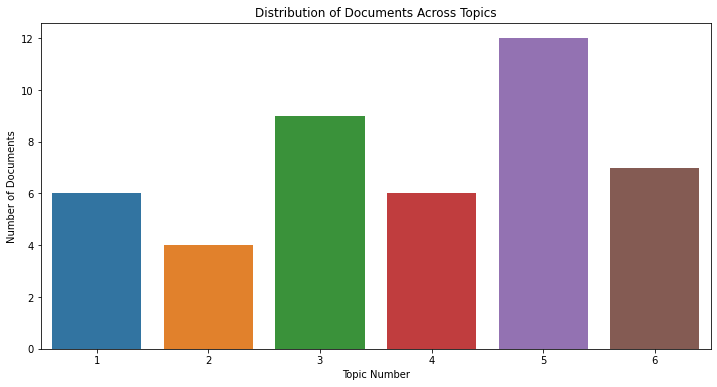

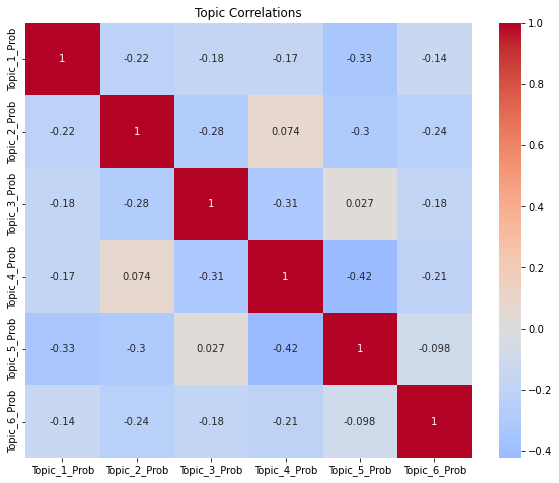

In [46]:
topic_modeler = TopicModelingCore()
df, topic_summaries = topic_modeler.apply_topic_modeling(
    df, 
    'content_lemmatized_enhanced_clean',
    min_topics=5,   
    max_topics=8,   
    step=1          
)
topic_modeler.print_topics(topic_summaries)
topic_modeler.plot_topic_distribution(df)
topic_modeler.plot_topic_correlations(df)

In [47]:
df.head()
df[['filename','dominant_topic']].head(10)

,filename,dominant_topic
0,1.txt,3
1,10.txt,5
2,105.txt,4
3,106.txt,4
4,107.txt,4
5,108.txt,2
6,11.txt,5
7,110.txt,1
8,111.txt,1
9,112.txt,1


In [48]:
df[['filename','dominant_topic']].tail()

,filename,dominant_topic
39,8.txt,5
40,82.txt,3
41,89.txt,4
42,9.txt,5
43,91.txt,4


In [49]:
class EntityNetworkAnalyzer:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")
        # mapping person/orgs to countries to avoid obvious connections
        self.country_person_map = {
            'french': ['sarkozy', 'levitte', 'jeandavid levitte', 'nicolas sarkozy', 'pierre vimont', 'france', 'ricard', 'pernod'],
            'afghanistan': [],
            'european': ['herman van rompuy', 'marianne fischer-boel', 'klaus-dieter borchardt', 'eads'],
            'washington': ['obama', 'john kerry', 'john negroponte', 'george w bush', 'cheney'],
            'japanese': ['shinzo abe', 'toshikatsu matsuoka', 'masakazu toyoda', 'nobutaka machimura', 'kono', 'fujitsu', 'toshiba'],
            'israeli': ['binyamin netanyahu', 'golda meir'],
            'german': ['angela merkel', 'bernd pfaffenback'],
            'italian': ['silvio berlusconi', 'valentino valentini'],
            'kosovo': ['soren jessen-petersen', 'wolfgang nikolaus', 'mark gough', 'james wasserstrom'],
            'slovakia': ['vintzislav stokykov', 'stoykov'],
            'zambia': ['dickson mzumara', 'mzumara'],
            'india': ['sanjaya bahel', 'nishan kohli'],
            'ethiopia': ['hiwot abebe'],
            'seychelles': ['ali todaro'],
            'international_orgs': ['monuc', 'unmil', 'iata', 'icaa'],
            'american_companies': ['dell', 'compaq', 'ibm'],
            'finnish_companies': ['nokia'],
            'french_companies': ['axa'],
            'chinese': [],
            'african': ['africa'],
            'icelandic': [],
            'somali': []
        }

    def normalize_entity(self, entity):
        """Normalize entity names to prevent redundant pairs"""
        parts = entity.lower().split()
        return ' '.join(sorted(set(parts)))

    def is_subset_entity(self, entity1, entity2):
        """Check if one entity is subset of another"""
        words1 = set(entity1.lower().split())
        words2 = set(entity2.lower().split())
        return words1.issubset(words2) or words2.issubset(words1)

    def create_entity_network(self, df, text_column):
        """Create network from named entities with disambiguation"""
        # Flatten the list of associated persons
        associated_persons = [person.lower() for persons in self.country_person_map.values() 
                            for person in persons]
        
        G = nx.Graph()
        entity_pairs = defaultdict(int)
        
        for text in df[text_column]:
            doc = self.nlp(str(text))
            
            # Get and normalize entities
            entities = [(self.normalize_entity(ent.text), ent.label_) for ent in doc.ents]
            
            # Filter entities
            filtered_entities = []
            for entity, label in entities:
                is_associated_person = any(entity in persons 
                                         for persons in self.country_person_map.values())
                if not is_associated_person:
                    filtered_entities.append((entity, label))
            
            # Create entity pairs
            for i, (entity1, label1) in enumerate(filtered_entities):
                for entity2, label2 in filtered_entities[i+1:]:
                    if entity1 != entity2 and not self.is_subset_entity(entity1, entity2):
                        same_country = False
                        for country, persons in self.country_person_map.items():
                            if (entity1 == country.lower() and entity2 in persons) or \
                               (entity2 == country.lower() and entity1 in persons):
                                same_country = True
                                break
                        
                        if not same_country:
                            pair = tuple(sorted([entity1, entity2]))
                            entity_pairs[pair] += 1
        
        # Add edges to graph
        for (entity1, entity2), weight in entity_pairs.items():
            if weight > 1:
                G.add_edge(entity1, entity2, weight=weight)
        
        return G, entity_pairs

    def get_entity_type(self, entity):
        """Determine entity type"""
        entity = entity.lower()
        if entity in self.country_person_map:
            return 'Country/Region'
        elif entity in self.country_person_map.get('international_orgs', []):
            return 'International Org'
        elif any(entity in values for key, values in self.country_person_map.items() 
                if 'companies' in key.lower()):
            return 'Company'
        elif any(entity in values for key, values in self.country_person_map.items()):
            return 'Person'
        return 'Other'

    def analyze_key_connections(self, G, entity_pairs):
        """Analyze network connections and patterns"""
        sorted_connections = sorted(entity_pairs.items(), 
                                  key=lambda x: x[1], 
                                  reverse=True)
        
        print("\nTop Connection Analysis:")
        print("-" * 50)
        
        # Strongest connections
        print("\n1. Strongest Entity Connections:")
        for (entity1, entity2), weight in sorted_connections[:10]:
            print(f"{entity1} -- {entity2}: {weight} co-occurrences")
        
        # Group by entity types
        connection_types = defaultdict(list)
        for (entity1, entity2), weight in sorted_connections:
            type1 = self.get_entity_type(entity1)
            type2 = self.get_entity_type(entity2)
            pair_type = tuple(sorted([type1, type2]))
            connection_types[pair_type].append((entity1, entity2, weight))
        
        # Network metrics
        print("\n2. Network Metrics:")
        degree_cent = nx.degree_centrality(G)
        print("\nMost Central Entities:")
        for entity, cent in sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:5]:
            print(f"  {entity}: {cent:.3f}")
        
        between_cent = nx.betweenness_centrality(G)
        print("\nKey Bridge Entities:")
        for entity, cent in sorted(between_cent.items(), key=lambda x: x[1], reverse=True)[:5]:
            print(f"  {entity}: {cent:.3f}")

        return connection_types

    def visualize_filtered_network(self, G):
        """Visualize the entity network"""
        plt.figure(figsize=(20, 20))
        
        # Calculate metrics
        centrality = nx.degree_centrality(G)
        node_size = [v * 8000 for v in centrality.values()]
        edge_weights = [G[u][v]['weight']/2 for u, v in G.edges()]
        
        # Assign colors
        node_colors = [self.get_node_color(node) for node in G.nodes()]
        
        # Create layout
        pos = nx.spring_layout(G, k=1.5, iterations=50)
        
        # Draw network
        nx.draw(G, pos,
               node_color=node_colors,
               node_size=node_size,
               font_size=10,
               width=edge_weights,
               with_labels=True,
               edge_color='gray',
               alpha=0.7)
        
        # Add legend
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', 
                      markerfacecolor='#1f77b4', label='Countries/Regions',
                      markersize=10),
            plt.Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='#2ca02c', label='International Orgs',
                      markersize=10),
            plt.Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='#ff7f0e', label='Companies',
                      markersize=10),
            plt.Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='#d62728', label='People',
                      markersize=10),
            plt.Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='#9467bd', label='Other Entities',
                      markersize=10)
        ]
        plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
        
        plt.title("Entity Relationship Network", fontsize=16, pad=20)
        
        # Add edge labels for strong connections
        edge_labels = {(u, v): f"{d['weight']}" 
                      for (u, v, d) in G.edges(data=True) 
                      if d['weight'] > 20}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
        
        plt.tight_layout()
        plt.show()

    def get_node_color(self, node):
        """Determine node color based on entity type"""
        node = node.lower()
        if node in self.country_person_map:
            return '#1f77b4'  # blue
        elif node in self.country_person_map.get('international_orgs', []):
            return '#2ca02c'  # green
        elif any(node in values for key, values in self.country_person_map.items() 
                if 'companies' in key.lower()):
            return '#ff7f0e'  # orange
        elif any(node in values for key, values in self.country_person_map.items()):
            return '#d62728'  # red
        return '#9467bd'  # purple
    
    def visualize_3d_network(self, G, filename='entity_network_3d.html'):
        """
        Create an interactive 3D network visualization using Plotly
        """
        # Calculate 3D layout
        pos_3d = nx.spring_layout(G, dim=3, k=1)
        
        # Extract coordinates
        x_nodes = [pos[0] for pos in pos_3d.values()]
        y_nodes = [pos[1] for pos in pos_3d.values()]
        z_nodes = [pos[2] for pos in pos_3d.values()]
        
        # Create edge traces
        edge_x = []
        edge_y = []
        edge_z = []
        
        for edge in G.edges():
            x0, y0, z0 = pos_3d[edge[0]]
            x1, y1, z1 = pos_3d[edge[1]]
            
            edge_x.extend([x0, x1, None])
            edge_y.extend([y0, y1, None])
            edge_z.extend([z0, z1, None])
        
        # Create edge trace with fixed width
        edge_trace = go.Scatter3d(
            x=edge_x, y=edge_y, z=edge_z,
            mode='lines',
            line=dict(
                color='rgba(150,150,150,0.3)',
                width=1
            ),
            hoverinfo='none'
        )
        
        # Create node traces by entity type
        node_traces = []
        
        # Get node attributes
        centrality = nx.degree_centrality(G)
        
        # Group nodes by type
        nodes_by_type = defaultdict(list)
        for node in G.nodes():
            node_type = self.get_entity_type(node)
            nodes_by_type[node_type].append(node)
        
        # Color mapping
        color_map = {
            'Country/Region': '#1f77b4',
            'International Org': '#2ca02c',
            'Company': '#ff7f0e',
            'Person': '#d62728',
            'Other': '#9467bd'
        }
        
        # Create separate trace for each entity type
        for node_type, nodes in nodes_by_type.items():
            if nodes:  # Only create trace if there are nodes of this type
                node_x = [pos_3d[node][0] for node in nodes]
                node_y = [pos_3d[node][1] for node in nodes]
                node_z = [pos_3d[node][2] for node in nodes]
                
                # Create hover text
                hover_text = [f"{node}<br>Connections: {G.degree(node)}" for node in nodes]
                
                node_trace = go.Scatter3d(
                    x=node_x, y=node_y, z=node_z,
                    mode='markers+text',
                    name=node_type,
                    marker=dict(
                        size=[centrality[node] * 30 + 10 for node in nodes],  # Base size + centrality scaling
                        color=color_map.get(node_type, '#9467bd'),
                        opacity=0.8,
                        symbol='circle'
                    ),
                    text=nodes,
                    hovertext=hover_text,
                    hoverinfo='text',
                    textposition="top center"
                )
                node_traces.append(node_trace)
        
        # Create figure
        fig = go.Figure(data=[edge_trace] + node_traces)
        
        # Update layout
        fig.update_layout(
            title={
                'text': "3D Entity Network Visualization",
                'y':0.95,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top'
            },
            showlegend=True,
            scene=dict(
                xaxis=dict(showticklabels=False, showgrid=False),
                yaxis=dict(showticklabels=False, showgrid=False),
                zaxis=dict(showticklabels=False, showgrid=False),
                bgcolor='white'
            ),
            margin=dict(l=0, r=0, t=40, b=0),
            legend=dict(
                yanchor="top",
                y=0.99,
                xanchor="left",
                x=0.01,
                bgcolor="rgba(255, 255, 255, 0.8)"
            ),
            scene_camera=dict(
                up=dict(x=0, y=0, z=1),
                center=dict(x=0, y=0, z=0),
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        )
        
        # Update scene aspects
        fig.update_scenes(
            aspectmode='data',
            dragmode='orbit'
        )
        
        # Show plot in browser
        fig.write_html(filename, auto_open=True)
        return fig


Top Connection Analysis:
--------------------------------------------------

1. Strongest Entity Connections:
french -- washington: 84 co-occurrences
cabrera walter -- cresta: 60 co-occurrences
afghanistan -- french: 44 co-occurrences
european -- french: 44 co-occurrences
french -- iraq: 27 co-occurrences
cabrera walter -- india: 24 co-occurrences
cabrera walter -- sony: 24 co-occurrences
afghanistan -- washington: 24 co-occurrences
european -- washington: 24 co-occurrences
french -- iran: 22 co-occurrences

2. Network Metrics:

Most Central Entities:
  washington: 0.256
  french: 0.202
  european: 0.186
  japan: 0.178
  bush: 0.171

Key Bridge Entities:
  washington: 0.213
  european: 0.173
  japan: 0.146
  bush: 0.144
  italian: 0.112


C:\Users\ellio\AppData\Local\Temp\ipykernel_7840\3222024090.py:189: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



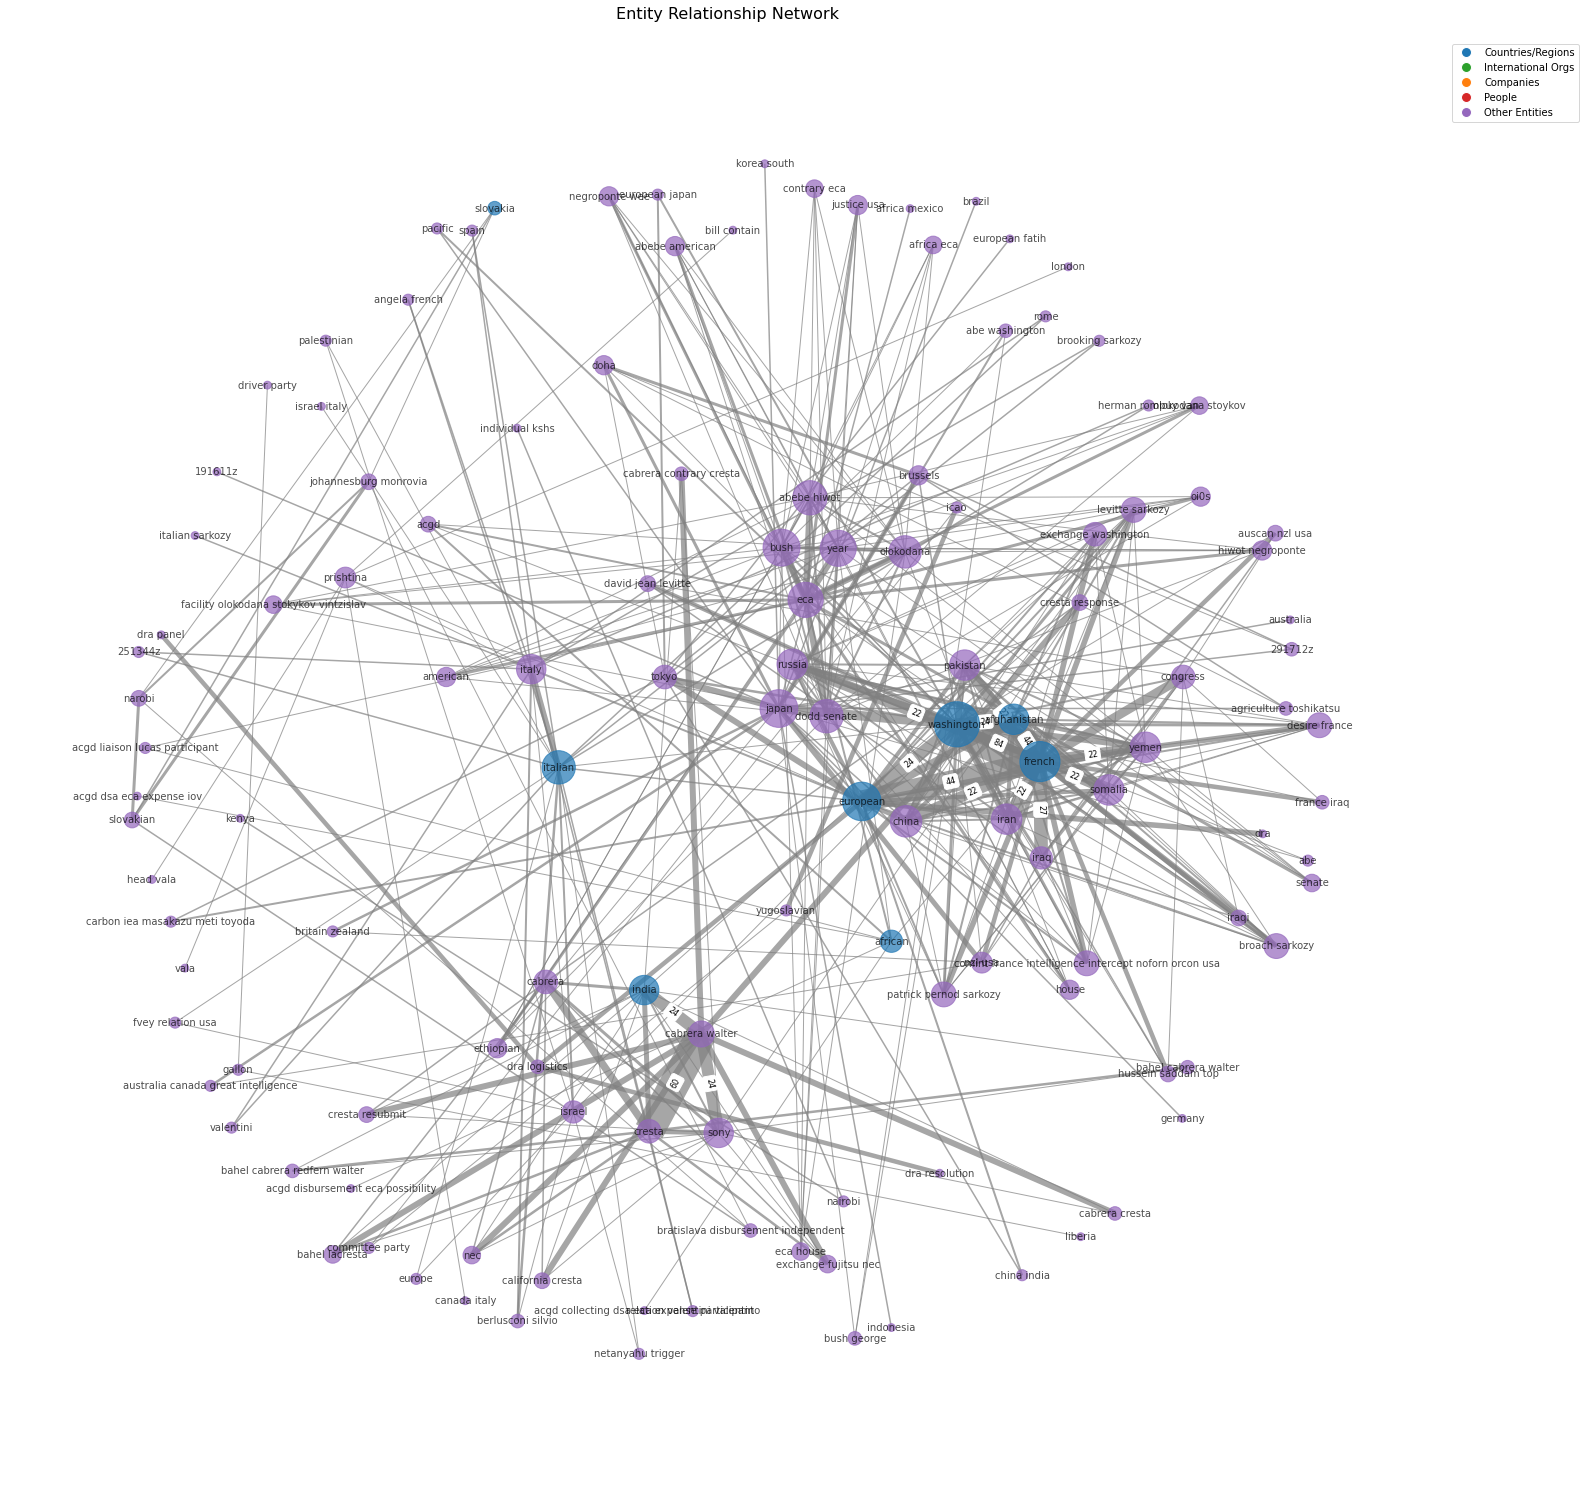

In [50]:
analyzer = EntityNetworkAnalyzer()
G, entity_pairs = analyzer.create_entity_network(df, 'content_lemmatized_enhanced_clean')
analyzer.analyze_key_connections(G, entity_pairs)
analyzer.visualize_filtered_network(G)
analyzer.visualize_3d_network(G, 'my_network.html')
